# **Misinformation Replies Analysis**

In this notebook we perform labelling on the dataset of misinformation replies using our trained model and also perform analysis on the results.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installing libraries

!pip install transformers
!pip install nltk emoji==0.6.0
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 3.8 MB/s 
     |████████████████████████████████| 596 kB 51.8 MB/s 
     |████████████████████████████████| 6.6 MB 75.4 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 2.8 MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49734 sha256=1df98b8c401e7852f614f4fafbe85b0730deda23c9ce190f0176787d0a329e02
  Stored in directory: /root/.cache/pip/wheels/4e/bf/6b/2e22b3708d14bf6384f862db539b044d6931bd6b14ad3c9adc
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

## Pre-processing the dataset

In [3]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

from sklearn import metrics
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd


import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, AutoTokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
# Importing reply dataset

reply_df = pd.read_csv('/content/drive/MyDrive/CovidEmo/ReplyTweets.csv')

In [5]:
reply_df.head(1000000)

,Unnamed: 0,Original,ID,Tweet
0,0,1265084253357907969,1266507730564481025,@AC360 #Moderna #VaccineFraud I'm not thinking...
1,1,1265084253357907969,1266124937766547457,"@AC360 Someone should tell Ian about VAERS, th..."
2,2,1265084253357907969,1265868550243266560,@KenBurkeJr @AC360 It's so sad that there are ...
3,3,1265084253357907969,1265868117114322944,@jcsweets31 @AC360 More Koolaid Please. I'll t...
4,4,1265084253357907969,1265867974155677696,"@_seashellsssss @AC360 Remember, this vaccine ..."
...,...,...,...,...
38968,38968,1252668808453672966,1252689553921585153,@LeaderHoyer Wtf? Originate this as bill now a...
38969,38969,1252668808453672966,1252674789912838144,@LeaderHoyer All the businesses here in South ...
38970,38970,1252668808453672966,1252671980786069509,@LeaderHoyer Just a reminder that the American...
38971,38971,1252668808453672966,1252668810357886976,"Lastly, I told press that I am distressed by P..."


In [6]:
label_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


emotion_df = pd.DataFrame(0.5, index=np.arange(len(reply_df)), columns=label_cols)

emotion_df.head(100000)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...
38968,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
38969,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
38970,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
38971,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [7]:
frames = [reply_df, emotion_df]
df = pd.concat(frames, axis=1)

df.drop(['ID', 'Original', 'Unnamed: 0'], inplace=True, axis=1)
df.reset_index(drop=True)
df.head()

,Tweet,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,@AC360 #Moderna #VaccineFraud I'm not thinking...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,"@AC360 Someone should tell Ian about VAERS, th...",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,@KenBurkeJr @AC360 It's so sad that there are ...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,@jcsweets31 @AC360 More Koolaid Please. I'll t...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,"@_seashellsssss @AC360 Remember, this vaccine ...",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [8]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

def normalise_dataset(dataset):
  for entry in dataset['Tweet']:
    dataset['Tweet'] = dataset['Tweet'].replace(entry, normalizeTweet(entry))

normalise_dataset(df)

In [9]:
tf.random.set_seed(1234)
bert_model_name = "vinai/bertweet-large"

tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
MAX_LEN = 64

def tokenize_sentences(sentences, tokenizer, max_seq_len = 64):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  
                            add_special_tokens = True,
                            truncation=True,
                            max_length = max_seq_len,
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

reply_input_ids = tokenize_sentences(df['Tweet'], tokenizer, MAX_LEN)
reply_inputs = pad_sequences(reply_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
reply_masks = create_attention_masks(reply_inputs)

reply_labels =  df[label_cols].values

  0%|          | 0/38973 [00:00<?, ?it/s]

In [12]:
print(reply_input_ids[3500])
print(tokenizer.decode(reply_input_ids[3500]))

[0, 1039, 47955, 38, 128, 119, 6661, 70, 754, 12, 33851, 2301, 32, 159, 23, 42, 86, 2540, 486, 2115, 754, 1649, 423, 2]
<s>@USER I'm sorry all fact-checking lines are down at this time please call upon fact check later</s>


In [13]:
# Create datasets

BATCH_SIZE = 16
NR_EPOCHS = 3

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    return dataset


reply_dataset = create_dataset((reply_inputs, reply_masks), batch_size=BATCH_SIZE, train=False, epochs=1)

## Create the model and load weights

In [14]:
from transformers import TFBertModel, TFAutoModel, AutoTokenizer, TFRobertaModel


class AutoClassifier(tf.keras.Model):
      def __init__(self, bert: TFRobertaModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = tf.keras.layers.Dense(num_classes, activation='sigmoid')
        self.pre_classifier = tf.keras.layers.Dense(2048, activation='relu')

      @tf.function
      def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)

        cls_output = outputs[1]
        cls_output = self.pre_classifier(cls_output)
        cls_output = self.classifier(cls_output)
                
        return cls_output


model = AutoClassifier(TFAutoModel.from_pretrained(bert_model_name), len(label_cols))

Some layers from the model checkpoint at vinai/bertweet-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta/pooler/dense/bias:0', 'roberta/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
print(reply_inputs[:1])

model(reply_inputs[:1],reply_masks[:1]).numpy()
model.summary()

[[    0  1039 47955   849 39631   102   849   846  7904   833   597 20202
     38   128   119    45  2053    42    16    10  2793   517    13  5965
   6280  7254  1666     2     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Model: "auto_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_roberta_model (TFRoberta  multiple                 355359744 
 Model)                                                          
                                                                 
 dense (Dense)               multiple                  16392     
                                                                 
 dense_1 (Dense)             multiple                  2099200   
                                                 

In [16]:
model.load_weights('/content/drive/MyDrive/Models/covid3.h5')

## Run inference on the data using the model

In [20]:
df_result = df.copy(deep=True)
df_result = df_result.drop_duplicates('Tweet', keep='first')

df_result[label_cols] = 0.5
df_result.set_index('Tweet', inplace=True)
print(df_result)

                                                    anger  anticipation  \
Tweet                                                                     
@USER #Moderna #VaccineFraud I 'm not thinking ...    0.5           0.5   
@USER Someone should tell Ian about VAERS , the...    0.5           0.5   
@USER @USER It 's so sad that there are such st...    0.5           0.5   
@USER @USER More Koolaid Please . I 'll take th...    0.5           0.5   
@USER @USER Remember , this vaccine is only tes...    0.5           0.5   
...                                                   ...           ...   
@USER Wtf ? Originate this as bill now and do n...    0.5           0.5   
@USER All the businesses here in South Carolina...    0.5           0.5   
@USER Just a reminder that the American people ...    0.5           0.5   
Lastly , I told press that I am distressed by P...    0.5           0.5   
I also said that Democrats will work to ensure ...    0.5           0.5   

                        

In [21]:
for i, (token_ids, masks) in enumerate(tqdm(reply_dataset)):
    
    sample_ids = df.iloc[i*BATCH_SIZE:(i+1)*BATCH_SIZE]['Tweet']
    
    predictions = model(token_ids, attention_mask=masks).numpy()

    df_result.loc[sample_ids, label_cols] = predictions

  0%|          | 0/2436 [00:00<?, ?it/s]

In [55]:
df_result.head(100000)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
Tweet,,,,,,,,
@USER #Moderna #VaccineFraud I 'm not thinking this is a smart move for Ian Haydon ...,0.818411,0.377291,0.598076,0.036835,0.003584,0.311440,0.049836,0.013733
"@USER Someone should tell Ian about VAERS , the Vaccine Adverse Event Reporting system , yes that 's right vaccines do n't work for all",0.801432,0.317897,0.423001,0.012195,0.008703,0.341323,0.084993,0.022357
@USER @USER It 's so sad that there are such stupid people in the world . Does he know what this is doing to his DNA ? I 'm sure they must have told him not to have any children . Because of the vaccine changing him forEVER . But who needs informed consent ? Nuremberg went out the window .,0.861810,0.085531,0.818194,0.094440,0.000610,0.951453,0.013019,0.003298
@USER @USER More Koolaid Please . I 'll take the - - Never mind the pill . Just give me every shot you got . I 'm not a bot .,0.252178,0.422952,0.271506,0.001852,0.313986,0.054592,0.029767,0.031503
"@USER @USER Remember , this vaccine is only tested on the healthiest people . Therefore , it is unknown if it is safe for people with any conditions whatsoever . Given how sick Americans are despite $ $ $ on healthcare , doubtful many can - - or should--take it . Ooops . money into the toilet .",0.069403,0.739665,0.053727,0.328247,0.004474,0.624721,0.031876,0.021167
...,...,...,...,...,...,...,...,...
@USER Wtf ? Originate this as bill now and do n't pass anything without these ... and climate as core to recovery as well,0.939836,0.308665,0.567040,0.008866,0.024444,0.133991,0.042653,0.019059
"@USER All the businesses here in South Carolina who got money , laid off employees for 3 weeks , reopening today should have to refund it . @USER @USER",0.771597,0.204342,0.402797,0.002658,0.020164,0.614807,0.010647,0.008066
@USER Just a reminder that the American people need more than $ 1200 to survive and ultimately bail out this country . Seriously .,0.222745,0.552831,0.188062,0.110031,0.018186,0.443062,0.012601,0.046152


In [23]:
y_pred = df_result[label_cols].values

thresh = 0.36
y_pred = np.array([[1 if i > thresh else 0 for i in j] for j in y_pred])

[1 1 1 0 0 0 0 0]


In [92]:
x = [[True if i > thresh else False for i in j] for j in df_result[label_cols].values]

emotion_df = pd.DataFrame(x, columns = label_cols)
final = emotion_df.set_index(df_result.index)

In [93]:
final.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
Tweet,,,,,,,,
@USER #Moderna #VaccineFraud I 'm not thinking this is a smart move for Ian Haydon ...,True,True,True,False,False,False,False,False
"@USER Someone should tell Ian about VAERS , the Vaccine Adverse Event Reporting system , yes that 's right vaccines do n't work for all",True,False,True,False,False,False,False,False
@USER @USER It 's so sad that there are such stupid people in the world . Does he know what this is doing to his DNA ? I 'm sure they must have told him not to have any children . Because of the vaccine changing him forEVER . But who needs informed consent ? Nuremberg went out the window .,True,False,True,False,False,True,False,False
@USER @USER More Koolaid Please . I 'll take the - - Never mind the pill . Just give me every shot you got . I 'm not a bot .,False,True,False,False,False,False,False,False
"@USER @USER Remember , this vaccine is only tested on the healthiest people . Therefore , it is unknown if it is safe for people with any conditions whatsoever . Given how sick Americans are despite $ $ $ on healthcare , doubtful many can - - or should--take it . Ooops . money into the toilet .",False,True,False,False,False,True,False,False


In [102]:
final.to_csv("/content/drive/MyDrive/Misinformation/replies.csv")

In [101]:
for column in final:
  print("Cases of {} emotion present: {}".format(column, len(final[final[column] == True].index)))

# num_rows = len(final[final['trust'] == True].index)
# print(num_rows)

Cases of anger emotion present: 17618
Cases of anticipation emotion present: 14717
Cases of disgust emotion present: 16291
Cases of fear emotion present: 2801
Cases of joy emotion present: 7431
Cases of sadness emotion present: 9113
Cases of surprise emotion present: 2461
Cases of trust emotion present: 2354


In [104]:
for column in final:
  print("Percentage of {} emotion present: {}".format(column, len(final[final[column] == True].index)/len(final)))

Percentage of anger emotion present: 0.46280340443417045
Percentage of anticipation emotion present: 0.38659766733214246
Percentage of disgust emotion present: 0.42794473048229487
Percentage of fear emotion present: 0.07357885888410214
Percentage of joy emotion present: 0.19520332037406746
Percentage of sadness emotion present: 0.2393874119995797
Percentage of surprise emotion present: 0.06464747294315436
Percentage of trust emotion present: 0.06183671324997373


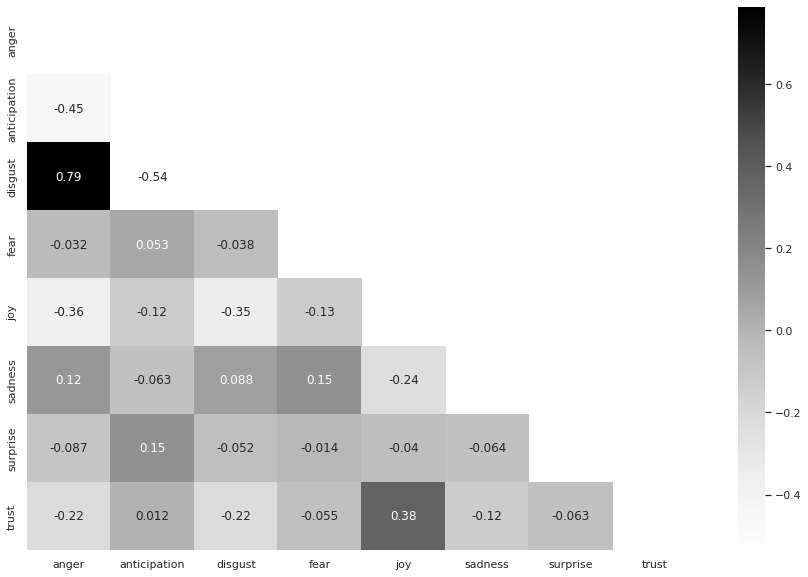

In [112]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.set_theme(style="white")


corr = final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True


heatmap = sns.heatmap(corr, mask=mask, annot=True, cmap="Greys", fmt='.2g')

## Original Tweets Classification